In [1]:
'''# downloading dataset from https://archive.materialscloud.org/record/2020.110

!wget "https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528" -O methane.extxyz.gz
!gunzip -k methane.extxyz.gz'''

'# downloading dataset from https://archive.materialscloud.org/record/2020.110\n\n!wget "https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528" -O methane.extxyz.gz\n!gunzip -k methane.extxyz.gz'

In [2]:
import numpy as np
import ase.io
import tqdm
from nice.blocks import *
from nice.utilities import *
from matplotlib import pyplot as plt
import sys
sys.path.append('./code/')
from code_pytorch import *
from utilities import *
import torch
from torch import nn
import torch.nn.functional as F

In [3]:
HARTREE_TO_EV = 27.211386245988
HYPERS = {
    'interaction_cutoff': 6.3,
    'max_radial': 5,
    'max_angular': 5,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.05,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'GTO'
}
train_subset = '0:1000'
test_subset = '1000:1500'
DEVICE = 'cuda'

In [4]:
train_structures = ase.io.read('methane.extxyz', index=train_subset)

test_structures = ase.io.read('methane.extxyz', index=test_subset)

all_species = get_all_species(train_structures + test_structures)

train_coefficients = get_spherical_expansion(train_structures, HYPERS,
                                             all_species, split_by_central_specie= False)

test_coefficients = get_spherical_expansion(test_structures, HYPERS,
                                            all_species, split_by_central_specie= False)

scaler = InitialScaler(mode='signal integral', individually=True)
scaler.fit(train_coefficients[0:500])

train_coefficients = scaler.transform(train_coefficients)
test_coefficients = scaler.transform(test_coefficients)


100%|██████████| 5/5 [00:00<00:00, 68.30it/s]


In [5]:
train_energies = [structure.info['energy'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV

test_energies = [structure.info['energy'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV

mean_e = np.mean(train_energies)
train_energies = train_energies - mean_e
test_energies = test_energies - mean_e

train_energies = torch.FloatTensor(train_energies).to(DEVICE)
test_energies = torch.FloatTensor(test_energies).to(DEVICE)

In [6]:
def get_nice_ps():
    return StandardSequence([     
        StandardBlock(None, None, None,
                      ThresholdExpansioner(mode='invariants'),
                      None,
                      None)
    ],
                            initial_scaler=None)
nice = get_nice_ps()
indices = np.random.permutation(train_coefficients.shape[0])[0:500]
nice.fit(train_coefficients[:500])

train_ps = torch.FloatTensor(nice.transform(train_coefficients, return_only_invariants = True)[2]).to(DEVICE)
test_ps = torch.FloatTensor(nice.transform(test_coefficients, return_only_invariants = True)[2]).to(DEVICE)

print(train_ps.shape)
print(test_ps.shape)

torch.Size([5000, 600])
torch.Size([2500, 600])


In [7]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.sequential = nn.Sequential(nn.Linear(600, 100), nn.Tanh(), nn.Linear(100, 1))
        
    def forward(self, X):
        return {'prediction' : self.sequential(X['ps'])}

models = {}
for key in all_species:
    models[str(key)] = Model()

In [8]:
def get_loss(predictions, targets):
    delta = predictions - targets
    return torch.mean(delta * delta)

In [9]:
print(torch.max(torch.LongTensor([1, 2, 4, 5, 2])).item())

5


In [10]:
def get_mae(first, second):
    return np.mean(np.abs(first - second))

def get_rmse(first, second):
    delta = first - second
    return np.sqrt(np.mean(delta * delta))

In [11]:
atomistic = Atomistic(models).to(DEVICE)
optim = torch.optim.Adam(atomistic.parameters())
train_structural_indices = get_structural_indices(train_structures)
test_structural_indices = get_structural_indices(test_structures)

train_central_species = get_central_species(train_structures)
test_central_species = get_central_species(test_structures)

train_atomic = {'ps' : train_ps, 'central_species' : train_central_species}
test_atomic = {'ps' : test_ps, 'central_species' : test_central_species}
train_struc = {'energies' : train_energies}
test_struc = {'energies' : test_energies}

BATCH_SIZE = 500
for epoch_num in range(1000):
    train_predictions = []
    for atomic_batch, structural_batch, b_struc_ind in iterate_minibatches(train_atomic, train_struc,
                                                  train_structural_indices, BATCH_SIZE):
        ps_now, central_species_now = atomic_batch['ps'], atomic_batch['central_species']
       
        energies_now = structural_batch['energies']
        
        predictions = atomistic({'ps' : ps_now}, central_species_now, b_struc_ind)['prediction'].squeeze()
        train_predictions.append(predictions.data.cpu().numpy())       
        loss = get_loss(predictions, energies_now)
        loss.backward()
        optim.step()
        optim.zero_grad()
    
    train_predictions = np.concatenate(train_predictions, axis = 0)
    if epoch_num % 100 == 0:
        print("train mae: ", get_mae(train_predictions, train_energies.data.cpu().numpy()))
        print("train rmse: ", get_rmse(train_predictions, train_energies.data.cpu().numpy()))
        
    test_predictions = []
    for atomic_batch, structural_batch, b_struc_ind in iterate_minibatches(test_atomic, test_struc,
                                                   test_structural_indices, BATCH_SIZE):
        ps_now, central_species_now = atomic_batch['ps'], atomic_batch['central_species']
        energies_now = structural_batch['energies']
        predictions = atomistic({'ps' : ps_now}, central_species_now, b_struc_ind)['prediction'].squeeze()
        test_predictions.append(predictions.data.cpu().numpy())
    test_predictions = np.concatenate(test_predictions, axis = 0)
    if epoch_num % 100 == 0:
        print("test mae: ", get_mae(test_predictions, test_energies.data.cpu().numpy()))
        print("test rmse: ", get_rmse(test_predictions, test_energies.data.cpu().numpy()))
    

train mae:  2.0145051
train rmse:  3.0031924
test mae:  2.1850777
test rmse:  3.4471397
train mae:  0.57089746
train rmse:  0.8351044
test mae:  0.6549264
test rmse:  1.1441635
train mae:  0.43956953
train rmse:  0.64467543
test mae:  0.5258223
test rmse:  0.9545119
train mae:  0.39664626
train rmse:  0.5632434
test mae:  0.48042306
test rmse:  0.8624156
train mae:  0.36899903
train rmse:  0.5113139
test mae:  0.45190978
test rmse:  0.8002405
train mae:  0.34038997
train rmse:  0.46248457
test mae:  0.42524368
test rmse:  0.7561142
train mae:  0.31777704
train rmse:  0.42444375
test mae:  0.40729633
test rmse:  0.73413336
train mae:  0.30192763
train rmse:  0.39952102
test mae:  0.3969538
test rmse:  0.7275868
train mae:  0.28944245
train rmse:  0.38160405
test mae:  0.39064172
test rmse:  0.7264903
train mae:  0.27726454
train rmse:  0.36543652
test mae:  0.38502392
test rmse:  0.7246202


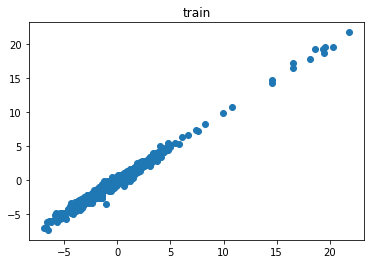

train rmse 0.34958708
train mae:  0.2650934


In [12]:
plt.plot(train_energies.data.cpu().numpy(), train_predictions, 'o')
plt.title("train")
plt.show()
print("train rmse", get_rmse(train_energies.data.cpu().numpy(), train_predictions))
print("train mae: ", get_mae(train_energies.data.cpu().numpy(), train_predictions))



test rmse 0.71985376
test mae:  0.37848175


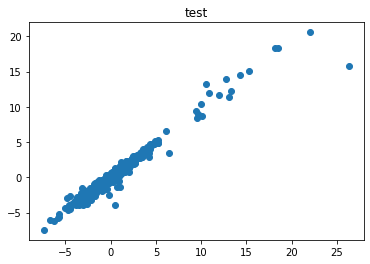

In [13]:
plt.plot(test_energies.data.cpu().numpy(), test_predictions, 'o')
plt.title("test")

print("test rmse", get_rmse(test_energies.data.cpu().numpy(), test_predictions))
print("test mae: ", get_mae(test_energies.data.cpu().numpy(), test_predictions))
plt.show()

initial:

train rmse 0.19329026
train mae:  0.14513983

test rmse 0.22161718
test mae:  0.15779226

dictionary:
    
train rmse 0.1894567
train mae:  0.14205378

test rmse 0.2163991
test mae:  0.15425898

train rmse 0.19735812
train mae:  0.14855184

test rmse 0.22645329
test mae:  0.16187958

In [14]:
train rmse 0.19252892
train mae:  0.14504704
    
test rmse 0.22191668
test mae:  0.15767235

SyntaxError: invalid syntax (<ipython-input-14-e62e0f6bde1d>, line 1)